In [1]:
import pandas as pd
import pandahouse as ph
import matplotlib as plt
import seaborn as sns
from scipy import stats
import hashlib
import numpy as np

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220920',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

query = '''
select post_id, 
       countIf(action = 'view') as views, 
       countIf(action = 'like') as likes, 
       uniq(user_id) as uniq_users 
from {db}.feed_actions 
where toDate(time) = yesterday() 
group by post_id 
order by views desc 
limit 10
'''

df = ph.read_clickhouse(query, connection=connection)
df

,post_id,views,likes,uniq_users
0,4450,17179,4752,12070
1,4554,17068,4913,11978
2,4467,16219,4481,11579
3,4538,15909,4430,11394
4,4487,15317,4138,11152
5,4551,15132,4027,11075
6,4562,14948,4014,11006
7,4553,14803,3910,10895
8,4586,13531,3352,10234
9,4595,13182,3237,9953


In [3]:
query2 = '''
select *
from {db}.feed_actions
limit 50
'''

df = ph.read_clickhouse(query2, connection=connection)
df.head()

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group
0,115269,2145,like,2022-09-04 20:40:27,1,19,Belarus,Vysokaye,Android,organic,4
1,122097,1854,view,2022-09-04 20:40:27,1,26,Russia,Nyazepetrovsk,Android,organic,4
2,132354,2119,view,2022-09-04 20:40:27,0,19,Russia,Ulan-Ude,Android,organic,1
3,134989,2024,view,2022-09-04 20:40:27,0,19,Russia,Novosibirsk,Android,organic,4
4,135083,2110,view,2022-09-04 20:40:27,0,17,Russia,Kostroma,iOS,organic,1


# Задание 1

В лекции мы выяснили, что при проведении АА-теста было бы здорово убедиться в том, что наша система сплитования работает корректно, и ключевая метрика не отличается между группами не только в конкретно нашем АА-тесте, но и в целом.

В идеале было бы здорово провести бесконечное количество АA-тестов и посмотреть, в каком количестве случаем нам удалось отклонить нулевую гипотезу. Если система сплитования работает корректно, то статистически значимые различия между двумя группами встречались бы только в результате случайного ложного срабатывания. Например, если мы отвергаем нулевую гипотезу при условии, что p_value < 0.05, то только приблизительно в 5% случаев у нас бы получались статистические значимые различия между 0 и 1 группой.

Понятное дело, что на практике провести бесконечное число тестов у нас навряд ли получится, поэтому используется небольшой трюк! Мы будем многократно извлекать подвыборки из наших данных, проводить t-test, и в конце посмотрим, в каком проценте случаев нам удалось отклонить нулевую гипотезу.

Итак, что нужно сделать: у нас есть данные АА-теста с '2022-08-27' по '2022-09-02'. Вам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

### Connection

In [4]:
q_ids = """
SELECT user_id, exp_group,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220820.feed_actions
WHERE toDate(time) >= '2022-08-27' and toDate(time) <= '2022-09-02'
AND exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q_ids, connection=connection)
df

,user_id,exp_group,likes,views,ctr
0,78186,2,20,83,0.240964
1,123580,3,8,29,0.275862
2,36785,3,6,33,0.181818
3,24239,2,58,163,0.355828
4,51455,3,12,62,0.193548
...,...,...,...,...,...
33128,76891,2,30,149,0.201342
33129,59057,2,32,160,0.200000
33130,77459,2,24,113,0.212389
33131,108927,2,21,74,0.283784


In [5]:
df.groupby('exp_group').user_id.nunique()

exp_group
2    16535
3    16598
Name: user_id, dtype: int64

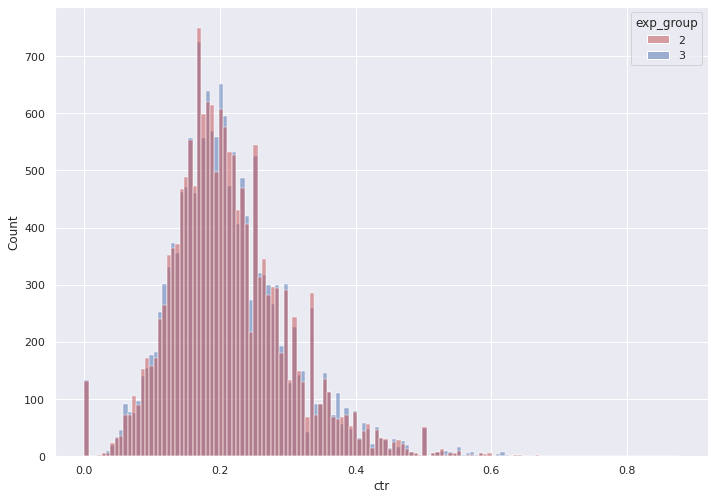

In [6]:
#Seaborn graph
sns.set(rc={'figure.figsize':(11.7, 8.27)})

groups = sns.histplot(data = df, 
    x='ctr', 
    hue='exp_group', 
    palette = ['r', 'b'],
    alpha=0.5,
    kde=False)

In [7]:
stats.ttest_ind(df[df.exp_group == 2].ctr, df[df.exp_group == 3].ctr, equal_var = False) 

Ttest_indResult(statistic=-1.0269615567179102, pvalue=0.30444606548572745)

### Booststrap

/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


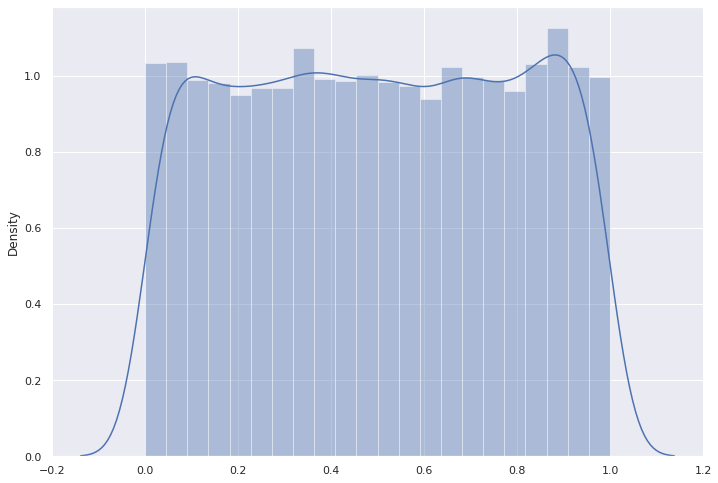

In [8]:
group_A = df[df.exp_group == 2].copy()
group_B = df[df.exp_group == 3].copy()

ps = []

for i in range (10000):
    _, p_value = stats.ttest_ind(group_A.ctr.sample(500, replace=False),
                                 group_B.ctr.sample(500, replace=False),
                                 equal_var = False)
    ps.append(p_value)
    
sns.distplot(ps);

In [9]:
sum(np.array(ps)<0.05)/10000

0.0506

Ответ: 5% p_value ~ 0.05

Вывод: т-тест по изначальному распределению показал значение p_value ~ 0.30 что является нормальным.

Проведя 10000 АА тестов, брав по 500 пользователей из каждой группы, мы достигли равномерного распределения p_value, что подтверждает нулевую гипотезу


### Task 2

Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2022-09-03 по 2022-09-09 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные АB-теста. 

Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? 
Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.
Ваше решение — это ссылка на merge request с проведенным анализом.

### Проверим что было на АА тесте этих двух групп

In [17]:
task_1 = """
SELECT user_id, exp_group,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220920.feed_actions
WHERE toDate(time) >= '2022-08-27' and toDate(time) <= '2022-09-02'
AND exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df_2_aa = ph.read_clickhouse(task_1, connection=connection)
df_2_aa.head(5)

,user_id,exp_group,likes,views,ctr
0,109963,1,2,15,0.133333
1,26117,1,13,35,0.371429
2,18392,1,8,39,0.205128
3,26295,1,4,9,0.444444
4,131473,2,26,148,0.175676


Ttest_indResult(statistic=-2.0172086421794484, pvalue=0.04368941747573794)


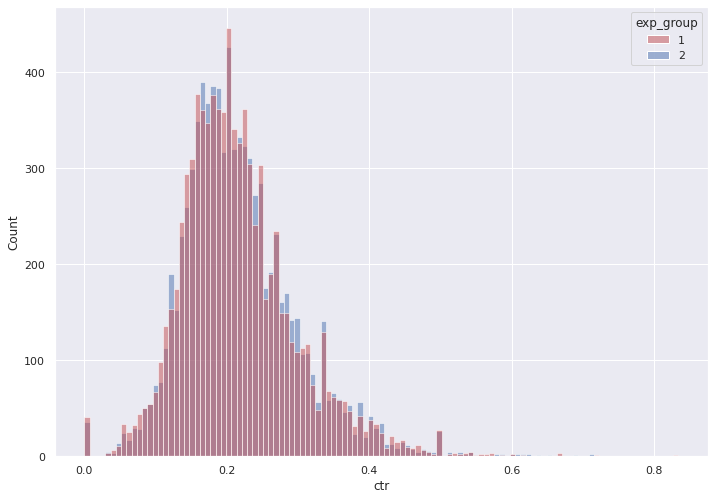

In [18]:
print(stats.ttest_ind(df_2_aa[df_2_aa.exp_group == 1].ctr, df_2_aa[df_2_aa.exp_group == 2].ctr, equal_var=False))
sns.histplot(data = df_2_aa, x='ctr', hue='exp_group', palette = ['r', 'b'], kde=False, alpha=0.5);

T-test и гистограмма говорят что группы статистически эквивалентны

### AB тест

In [23]:
task_2 = """
SELECT user_id, exp_group,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220920.feed_actions
WHERE toDate(time) >= '2022-09-03' and toDate(time) <= '2022-09-09'
AND exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df_2 = ph.read_clickhouse(task_2, connection=connection)
df_2

,user_id,exp_group,likes,views,ctr
0,109963,1,3,15,0.200000
1,26117,1,32,141,0.226950
2,138232,1,18,73,0.246575
3,26295,1,33,122,0.270492
4,18392,1,7,32,0.218750
...,...,...,...,...,...
20026,132567,1,45,296,0.152027
20027,30872,1,11,59,0.186441
20028,25383,2,42,127,0.330709
20029,139020,2,24,114,0.210526


### Сравним средние групп до и после AB теста

In [ ]:
print('Avg ctr for 1st group after AB testing is',df_2[df_2.exp_group == 1].ctr.mean())
print('Avg ctr for 2nd group after AB testing is', df_2[df_2.exp_group == 2].ctr.mean())

Avg ctr for 1st group after AB testing is 0.21560459841296287
Avg ctr for 2nd group after AB testing is 0.21441927347479375


In [ ]:
print('Avg ctr for 1st group before AB testing is',df_2_aa[df_2_aa.exp_group == 1].ctr.mean())
print('Avg ctr for 2nd group before AB testing is', df_2_aa[df_2_aa.exp_group == 2].ctr.mean())

Avg ctr for 1st group before AB testing is 0.21560459841296287
Avg ctr for 2nd group before AB testing is 0.21441927347479375


Средний CTR контрольной группы почти не изменился, средний CTR таргет группы изменился на ~0.004. Пока не впечатляет

### График распределения ctr после AB теста + t_test

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)


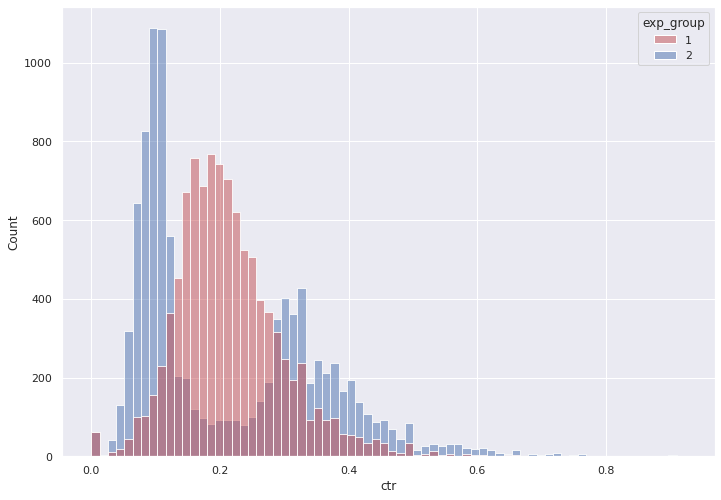

In [24]:
print(stats.ttest_ind(df_2[df_2.exp_group == 1].ctr, df_2[df_2.exp_group == 2].ctr, equal_var=False))
sns.histplot(data = df_2, x='ctr', hue='exp_group', palette = ['r', 'b'], kde=False, alpha=0.5);

На графике видно, что распределения очень разные и таргет группа имеет бимодальное распределение, а контрольная группа - унимодальное. В таком случае т-тест может работать не совсем корректно

### Mannwhitney

In [25]:
print(stats.mannwhitneyu(df_2[df_2.exp_group == 1].ctr, df_2[df_2.exp_group == 2].ctr, alternative='two-sided'))

print(' ')

A_gt_B = 0

for _ in range(10000):
    A_gt_B+= df_2[df_2.exp_group == 1].ctr.sample().values[0] > df_2[df_2.exp_group == 2].ctr.sample().values[0]
    
print('В', A_gt_B/100, 'случаев A>B. Должно получиться около 50%')    

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)
 
В 56.31 случаев A>B. Должно получиться около 50%


### Smoothed CTR

In [26]:
global_ctr = [0,0]
global_ctr[0] = df_2[df_2.exp_group == 1].likes.sum() / df_2[df_2.exp_group == 1].views.sum()
global_ctr[1] = df_2[df_2.exp_group == 2].likes.sum() / df_2[df_2.exp_group == 2].views.sum()

df_2['global_ctr'] = df_2.exp_group.apply(lambda x: global_ctr[0] if x == 1 else global_ctr[1])
df_2['smoothed_ctr'] = (df_2.likes + df_2.global_ctr * 5) / (df_2.views + 5)
df_2

,user_id,exp_group,likes,views,ctr,global_ctr,smoothed_ctr
0,109963,1,3,15,0.200000,0.208027,0.202007
1,26117,1,32,141,0.226950,0.208027,0.226302
2,138232,1,18,73,0.246575,0.208027,0.244104
3,26295,1,33,122,0.270492,0.208027,0.268033
4,18392,1,7,32,0.218750,0.208027,0.217301
...,...,...,...,...,...,...,...
20026,132567,1,45,296,0.152027,0.208027,0.152957
20027,30872,1,11,59,0.186441,0.208027,0.188127
20028,25383,2,42,127,0.330709,0.198060,0.325684
20029,139020,2,24,114,0.210526,0.198060,0.210003


### График распределения Smoothed CTR после AB теста + t_test

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)


<AxesSubplot:xlabel='smoothed_ctr', ylabel='Count'>

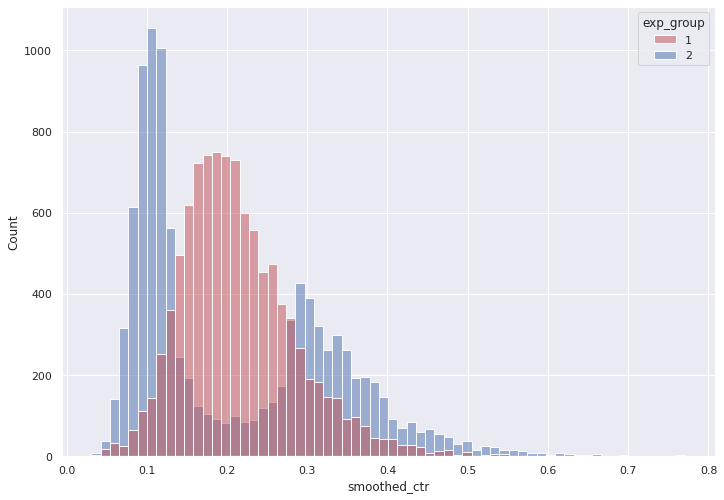

In [27]:
print(stats.ttest_ind(df_2[df_2.exp_group == 1].smoothed_ctr, df_2[df_2.exp_group == 2].smoothed_ctr, equal_var=False))
sns.histplot(data=df_2, x='smoothed_ctr', hue='exp_group', palette = ['r', 'b'], kde=False, alpha=0.5)

После сглаживания CTR результаты t-test изменились: сейчас он показывает что отличия есть, хотя распределение выглядит так же.

### Poisson Bootstrap

In [28]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
#weights
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

likes1 = df_2[df_2.exp_group == 1].likes.to_numpy()
views1 = df_2[df_2.exp_group == 1].views.to_numpy()
likes2 = df_2[df_2.exp_group == 2].likes.to_numpy()
views2 = df_2[df_2.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

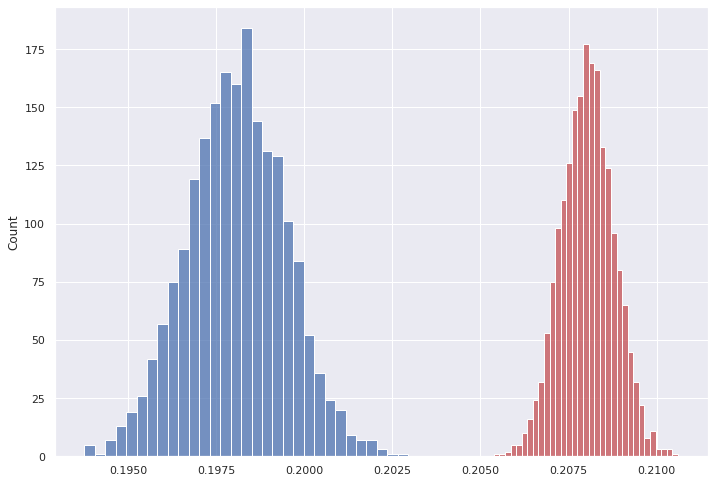

In [29]:
sns.histplot(ctr1, color='r');
sns.histplot(ctr2);

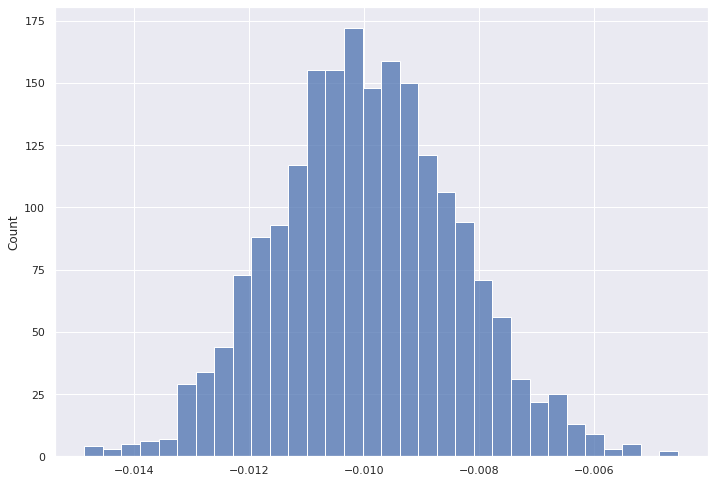

In [30]:
sns.histplot(ctr2-ctr1);

Распределения не пересекаются. Прикол в том, что глобальный CTR в таргет группе больше. Однозначно можно сказать, что алгоритм вводить не нужно

### Bucket

In [31]:
bucket_q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20220920.feed_actions
    WHERE toDate(time) between '2022-09-03' and '2022-09-09'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

bucket = ph.read_clickhouse(bucket_q, connection=connection)
bucket.head(5)

,exp_group,bucket,bucket_ctr,ctr9
0,1,0,0.196481,0.307692
1,2,0,0.194262,0.384615
2,1,1,0.211887,0.318182
3,2,1,0.215328,0.467742
4,1,2,0.206271,0.322314


In [32]:
stats.mannwhitneyu(bucket[bucket.exp_group == 1].bucket_ctr, bucket[bucket.exp_group == 2].bucket_ctr, alternative='two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)


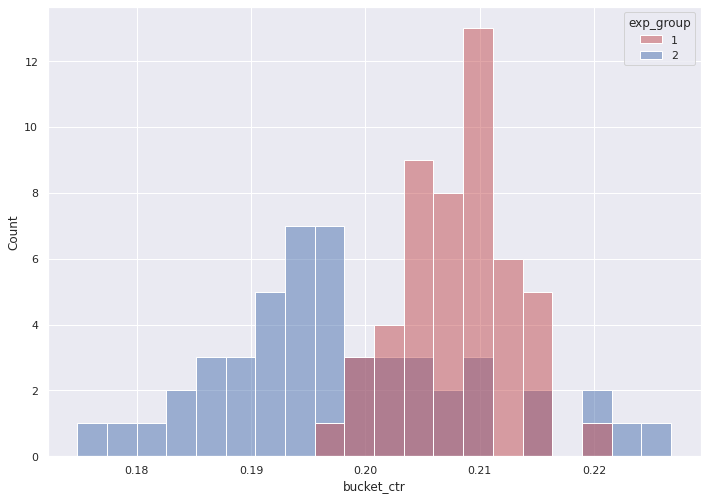

In [33]:
print(stats.ttest_ind(bucket[bucket.exp_group == 1].bucket_ctr, bucket[bucket.exp_group == 2].bucket_ctr, equal_var=False))
sns.histplot(data=bucket, x='bucket_ctr', hue='exp_group', palette = ['r','b'], bins=20);

Ман Витни и Т-тест видят различия в группах

# Заключение по заданию 2

Выборки однозначно различаются, об этом говорят все тесты, кроме т-теста (Скорее всего из-за распределения данных). При этом глобальный CTR таргет группы стал меньше, по отношению к контрольной группе.
Если вспомнить о самом алгоритме, то он был нацелен на то, чтобы показывать пользователю интересующие его посты. И в теории, пользователь мог просто смотреть больше постов, но не лайкать их, что очевидно полезно для компании. Кроме того могли быть пользователи, которые стали меньше смотреть и больше лайкать эти посты. Возможно причина в самом алгоритме рекомендаций - пользователям показывали не те посты, и поэтому их CTR - упал, такое падение наблюдается на первом горбу графика. А вторым пользователям посты наоборот начали заходить и они стали больше их лайкать. Исходя из этого мне кажется что нужно доработать систему алгоритмов и на данный момент точно не стоит пускать алгоритм в прод. В теории можно было бы построить гистограммы по гео,ос,гендеру итд и смотреть как там распределяются данные, но это outside of this scope а сейчас 16 сентября и у меня один день чтобы доделать домашку до максимально последнего дедлайна

# Task 3

При этом метод сам по себе очень прост. Что это за метрика такая?

*    Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
*    Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
*   После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠

Задача

Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [34]:
q3 = """
SELECT user_id, exp_group,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220920.feed_actions
WHERE toDate(time) >= '2022-09-03' and toDate(time) <= '2022-09-09'
AND exp_group in (0,1,2,3)
GROUP BY exp_group, user_id
"""

df3 = ph.read_clickhouse(q3, connection=connection)
df3.head(5)

,user_id,exp_group,likes,views,ctr
0,115383,3,9,30,0.300000
1,18392,1,7,32,0.218750
2,123580,3,13,48,0.270833
3,131473,2,14,134,0.104478
4,32420,2,26,128,0.203125


### Сравним группы 0 и 3

t-test

In [35]:
stats.ttest_ind(df3[df3['exp_group'] == 0].ctr, df3[df3['exp_group'] == 3].ctr, equal_var=False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

метод лайков

In [36]:
ctr_control_0 = df3[df3['exp_group'] == 0].likes.sum() / df3[df3['exp_group'] == 0].views.sum()
ctr_control_0
df3['linearized_likes_1'] = df3.likes - ctr_control_0 * df3.views


In [37]:
stats.ttest_ind(df3[df3['exp_group'] == 0].linearized_likes_1, df3[df3['exp_group'] == 3].linearized_likes_1, equal_var=False)

Ttest_indResult(statistic=-15.214995460903827, pvalue=5.4914249479690016e-52)

P-value снизилось, значения статистики -13.9 до и -15.2 после

### Сравним группы 1 и 2

t_test

In [38]:
stats.ttest_ind(df3[df3.exp_group == 1].ctr,
                df3[df3.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

метод лайков


In [39]:
ctr_control_2 = df3[df3.exp_group == 1].likes.sum() / df3[df3.exp_group == 2].views.sum()
df3['linearized_likes_2'] = df3.likes - ctr_control_2 * df3.views
stats.ttest_ind(df3[df3.exp_group == 1].linearized_likes_2,
                df3[df3.exp_group == 2].linearized_likes_2,
                equal_var=False)

Ttest_indResult(statistic=6.095120174775194, pvalue=1.1206169008511577e-09)

Тут тест лайков показывает значимые отличия, так как т-тест разницы не видел. Всему виной было то двухгорбое распределение. Значит метод лайков улучшил т-тест

<AxesSubplot:xlabel='linearized_likes_2', ylabel='Count'>

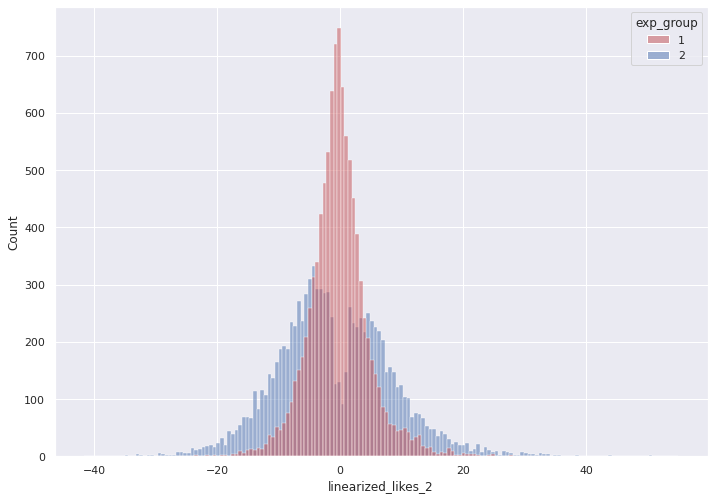

In [40]:
sns.histplot(data = df3.query('exp_group == 1 | exp_group == 2'), 
              x='linearized_likes_2', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)